<a href="https://colab.research.google.com/github/cu-applied-math/appm-4600-numerics/blob/lab_solutions/Labs/Lab13_Eigenvalues_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 13: beyond the simple power method for eigenvalues  SOLUTIONS

### Tasks
1. Code the *orthogonal iteration* and *QR iteration* and run it on the given matrix $A$
2. Code the *inverse iteration* (aka shift-and-invert power method) and run it on the given matrix $A$
3. Apply these codes to matrices that may have *complex eigenvalues* or non-unique dominant eigenvalues
4. (*Optional*) Examine the Rayleigh quotient iteration

### Deliverables
1. The output from task 1 (see below for details)
2. The output from task 2 (see below for details)

Combine these into a single PDF and upload to Canvas

### Learning objectives
- Understand the algorithms
- Examine convergence
- See what can go wrong and how complex eigenvalues affect things


*Copyright 2025, Department of Applied Mathematics, University of Colorado Boulder. Released under a BSD 3-clause license*

In [2]:
import numpy as np
import scipy.linalg as sla
from matplotlib import pyplot as plt

Let's use the following small matrix. We'll make things easy for ourselves by choosing a **symmetric** matrix, which guarantees that the eigenvalues are real

In [80]:
rng = np.random.default_rng(67)
n = 5
A = rng.integers(low=-3,high=9,size=(n,n))
A = A + A.T # make it symmetric, so eigenvalues are guaranteed to be real
print(A)
eigs = sla.eigvalsh(A)[::-1]
print(eigs)

[[12  4  8 -1  5]
 [ 4  8  2  7  3]
 [ 8  2 14 -2 -1]
 [-1  7 -2 -4  4]
 [ 5  3 -1  4 12]]
[23.56061053 15.91358247  7.7036999   2.92935241 -8.10724531]


# Task 1
Write code for both the **orthogonal iteration** and **QR iteration**.

We didn't discuss in much detail how you get your estimate of the eigenvalues, so put some thought into this. For the power method, if $\vec{x}$ (with $\|\vec{x}\|_2=1$) is our current iteration, we use the estimate $\mu = \vec{x}^\top A \vec{x}$.  So how can you generalize that when you have a matrix instead of a vector?

**Deliverable** Run both algorithms on the matrix $A$ from above, for 20 iterations.  In your PDF report, report both the *matrix* and the list of the *eigenvalues*.  If there's any apparent structure in the matrix, comment on that.

In [81]:
def orthogonal_iteration(A,X=None,r=None,maxits=100,rng = np.random.default_rng() ):
    A = np.asarray(A)
    if A.ndim != 2: raise ValueError("First input must be a 2d array, matrix-like")
    m, n = A.shape
    if m != n: raise ValueError("First input must be a square matrix")
    if X is None:
        if r is None:
            r = n # find all eigenvectors by default
        if r == n:
            X = np.eye(n)
        else:
            X = rng.standard_normal( (n,r) )
    else:
        if r is None: r = X.shape[1]
    X = sla.qr(X,mode='economic')[0]
    for k in range(maxits):
        Y = A@X
        # diag(Y.T@X) will be the equivalent of the Rayleigh quotient, but that's computationally slow
        diag = np.sum( Y*X, axis=0 )
        X = sla.qr(Y,mode='economic')[0]
    return X, diag

def QR_algorithm(A,maxits=100,printInfo=False):
    Ak = A.copy()
    for k in range(maxits):
        Q,R = sla.qr(Ak)
        Ak  = R@Q
        if printInfo:
            with np.printoptions(precision=2,suppress=True):
                print(Ak)
    return Ak, np.diag(Ak) # <-- our estimate of eigenvalues

In [82]:
X, eigs = orthogonal_iteration(A,maxits=20)
print(eigs)
with np.printoptions(precision=2,suppress=True):
    print(X)

[23.56061051 15.91358249 -1.57895636  1.17541095  2.92935241]
[[-0.66  0.06  0.27  0.12 -0.69]
 [-0.34 -0.35 -0.79 -0.35 -0.07]
 [-0.57  0.58 -0.01 -0.11  0.57]
 [-0.07 -0.32  0.51 -0.79  0.1 ]
 [-0.35 -0.66  0.19  0.48  0.42]]


In [83]:
X, eigs = QR_algorithm(A,maxits=20)
print(eigs)
with np.printoptions(precision=2,suppress=True):
    print(X)

[23.56061052 15.91358248 -1.96655577  1.56301036  2.92935241]
[[23.56  0.    0.   -0.    0.  ]
 [ 0.   15.91 -0.    0.    0.  ]
 [ 0.   -0.   -1.97  7.71 -0.  ]
 [-0.    0.    7.71  1.56 -0.  ]
 [ 0.    0.   -0.   -0.    2.93]]


SOLUTION

Code is above. Both of them converge fairly well after 20 iterations, but not perfectly. You can see that it gets 3 of 5 eigenvalues pretty well, but 2 of 5 are not resolved. Looking at the matrix from the QR algorithm, it looks almost diagonal, but we can still see a 2x2 block, corresponding to those 2 unresolved eigenvalues.

Note that these two eigenvalues that are unresolved have very similar *magnitudes* to each other.

*Note: we chose a symmetric matrix so it has real eigenvalues. If we had a asymmetric matrix and there were complex eigenvalues, then we would* **always** *get some 2x2 blocks. In the example above, we get those blocks for a different reason -- we just haven't converged yet.*

# Task 2: shift-and-invert power method / "Shifted inverse iteration" / ["inverse iteration"](https://en.wikipedia.org/wiki/Inverse_iteration)
Implement the shift-and-invert power method.  The user should supply a value for the shift, $q$, then the code performs the power method on the matrix $B=(A-qI)^{-1}$.

*Do not use the inverse explicitly!*

**Deliverable**

Run the inverse iteration code on the matrix $A$ from above, uing the shift $q$ to target the smallest (i.e., most negative) eigenvalue that you estimated using your QR iteration or orthogonal iteration.

In [86]:
def power_method(A,x=None,maxits=100, rng = np.random.default_rng(),
                 do_complex=False, shift=0, invert=False ):
    A = np.asarray(A)
    if A.ndim != 2: raise ValueError("First input must be a 2d array, matrix-like")
    m, n = A.shape
    if m != n: raise ValueError("First input must be a square matrix")
    if x is None:
        x = rng.standard_normal( n )
        if do_complex:
            x = x + 1j*rng.standard_normal( n )
    x = x/sla.norm(x)
    if invert:
        # Cache the LU factorization
        lu,piv = sla.lu_factor(A-shift*np.eye(n))
    muList = []
    for k in range(maxits):
        y = A@x - shift*x # shift
        muList.append( np.dot(y,x) )
        if invert:
            # y = sla.solve(A-shift*np.eye(n),x) # OK but slow
            y = sla.lu_solve((lu,piv),x) # better, re-uses LU factorization
        x = y/sla.norm(y)
    return np.array(muList) + shift, x

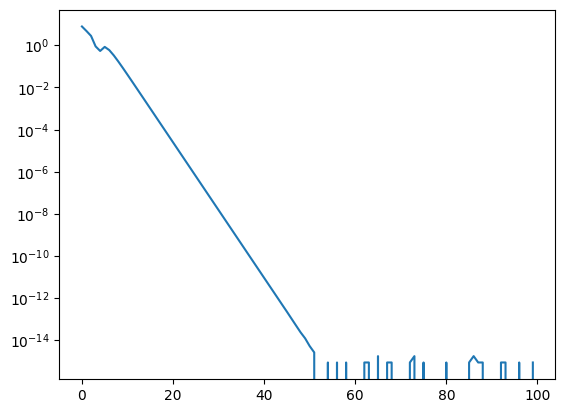

In [87]:
muList, v = power_method(A,shift=-1.5789,invert=True)
muList[-5:]
plt.semilogy(np.abs(muList - eigs[-1]))
plt.show()

# Task 3: complex eigenvalues

### 4.1 QR iteration
Use the matrix $B$ below, which is assymetric and so it could have complex eigenvalues, and run the QR iteration on it. What does it converge to?

### 4.2 Power method
For the matrix $C$ below, try the power method. Does it converge? If so, does it converge to what you expect? (You can check its eigenvalues using scipy)

### 4.3 Power method
For the matrix $D$ below, try the power method. Does it converge? If so, does it converge to what you expect?


**Deliverables**
Nothing required

In [93]:
rng = np.random.default_rng(67)
n = 5
B = rng.integers(low=-3,high=9,size=(n,n))

In [97]:
# SOLUTION
true_eigs = np.real_if_close( sla.eigvals(B) )

X, eigs = QR_algorithm(B,maxits=20)
with np.printoptions(precision=2,suppress=True):
    print(true_eigs)
    print(eigs)
    print(X)
    print(np.diag(X))

[11.32+0.j   -2.82+0.j    1.74+0.j    5.38+4.79j  5.38-4.79j]
[11.32  6.99  3.78 -2.82  1.74]
[[11.32 -0.4   2.43 -1.19 -2.8 ]
 [ 0.    6.99 -4.61  6.44 -0.8 ]
 [-0.    5.54  3.78 -2.73 -1.03]
 [ 0.    0.   -0.   -2.82  0.14]
 [ 0.   -0.   -0.   -0.    1.74]]
[11.32  6.99  3.78 -2.82  1.74]


SOLUTION

We see that it converges almost to a triangular matrix, but there is a 2x2 block on the diagonal (corresponding to its pair of complex eigenvalues)

In [99]:
C = np.array(( [[0,-25/4,0,0],[1,-4,0,0],[0,0,0,-41/4],[0,0,1,-5]]))
print(C)

[[  0.    -6.25   0.     0.  ]
 [  1.    -4.     0.     0.  ]
 [  0.     0.     0.   -10.25]
 [  0.     0.     1.    -5.  ]]


In [101]:
# SOLUTION
# This matrix has *only* complex eigenvalues, so its dominant eigenvalues are not unique
print(sla.eigvals(C))

muList, v = power_method(C,maxits=200)
muList[-10:]
# It doesn't converge!

[-2. +1.5j -2. -1.5j -2.5+2.j  -2.5-2.j ]


array([-4.62737904, -2.85191839, -1.46841505,  1.33224831, -7.32292217,
       -3.86446965, -2.39986113, -0.82731212,  2.744197  , -5.64654811])

In [105]:
rng = np.random.default_rng(67)
n = 5
D = rng.integers(low=-3,high=9,size=(n,n))
D = D - np.tril(D) + np.diag( [10,10,6,4,3])

In [108]:
# SOLUTION
true_eigs = np.real_if_close( sla.eigvals(D) )
print(true_eigs)

muList, v = power_method(D,maxits=500)
muList[-10:]
# It doesn't converge!

[10. 10.  6.  4.  3.]


array([10.02090295, 10.02085937, 10.02081597, 10.02077275, 10.0207297 ,
       10.02068684, 10.02064415, 10.02060164, 10.0205593 , 10.02051714])

# Task 4 (optional): Rayleigh quotient iteration
Implement the [**Rayleigh quotient**](https://en.wikipedia.org/wiki/Rayleigh_quotient_iteration) method (a simple implementation reference is at https://www.cs.utexas.edu/~flame/Notes/NotesOnPowerMethod.pdf)

This is the inverse iteration, but uses your best guess for the eigenvalue at every iteration for the shift, so it converges very fast.

**Deliverables**
Nothing required

In [89]:
def RayleighQuotient(A,x=None,maxits=12, rng = np.random.default_rng() ):
    A = np.asarray(A)
    if A.ndim != 2: raise ValueError("First input must be a 2d array, matrix-like")
    m, n = A.shape
    if m != n: raise ValueError("First input must be a square matrix")
    if x is None:
        x = rng.standard_normal( n )
    x = x/sla.norm(x)
    muList = []
    # If we want the dominant eigenvalue, then we should iterate a bit to make sure that's the one we converge to
    for k in range(5):
        y = A@x
        x = y/sla.norm(x)
    for k in range(maxits):
        mu = np.dot(x,A@x) # best estimate of eigenvalue so far
        y  = sla.solve( A-mu*np.eye(n), x)
        muList.append( mu )
        x = y/sla.norm(y)
    return np.array(muList), x

/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.23487e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=7.05812e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


[13054.43534858    23.55138925    23.56061052    23.56061053
    23.56061053    23.56061053    23.56061053    23.56061053
    23.56061053    23.56061053    23.56061053    23.56061053]


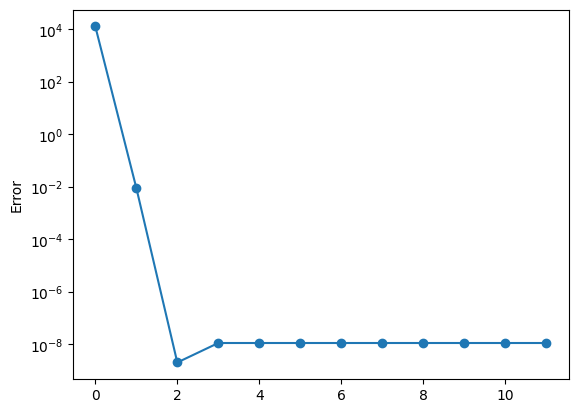

In [90]:
muList,v = RayleighQuotient(A)
print(muList)
plt.semilogy( np.abs(muList-eigs[0]), 'o-' )
plt.ylabel('Error')
plt.show()